# Import modules

In [17]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader


reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Plugins(categories=["generic"]).list()

assert device.type == 'cuda'


# Reload

In [18]:
import importlib
import DGE_experiments
import DGE_data
import DGE_utils
importlib.reload(DGE_experiments)
importlib.reload(DGE_data)
importlib.reload(DGE_utils)


<module 'DGE_utils' from '/home/bv292/synthcity/DGE_utils.py'>

# Load data and settings

In [20]:
from DGE_data import get_real_and_synthetic

dataset = ['moons', 'cal_housing', 'seer'][2]  # real data
model_name = 'ctgan'  # synthetic data model

nsyn = None  # number of synthetic data points per synthetic dataset. Defaults to same as generative training size if None
p_train = None  # proportion of training data for generative model. Default values if None
n_models = 20  # number of models in ensemble
load = True  # results

load_syn = True  # data
save = True  # save results and data
verbose = False


workspace_folder = os.path.join("workspace", dataset,model_name)
results_folder = os.path.join("uncertainty_results",dataset,model_name)

X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                      p_train=p_train,
                                      n_models=n_models,
                                      model_name=model_name,
                                      load_syn=load_syn,
                                      verbose=verbose)


nsyn = len(X_syns[0])
print('Shape of each synthetic dataset:', X_syns[0].shape)


n_total 20000 n_train: 10000


  0%|          | 8/2000 [00:03<14:59,  2.21it/s]

# Analyses

## Model Training

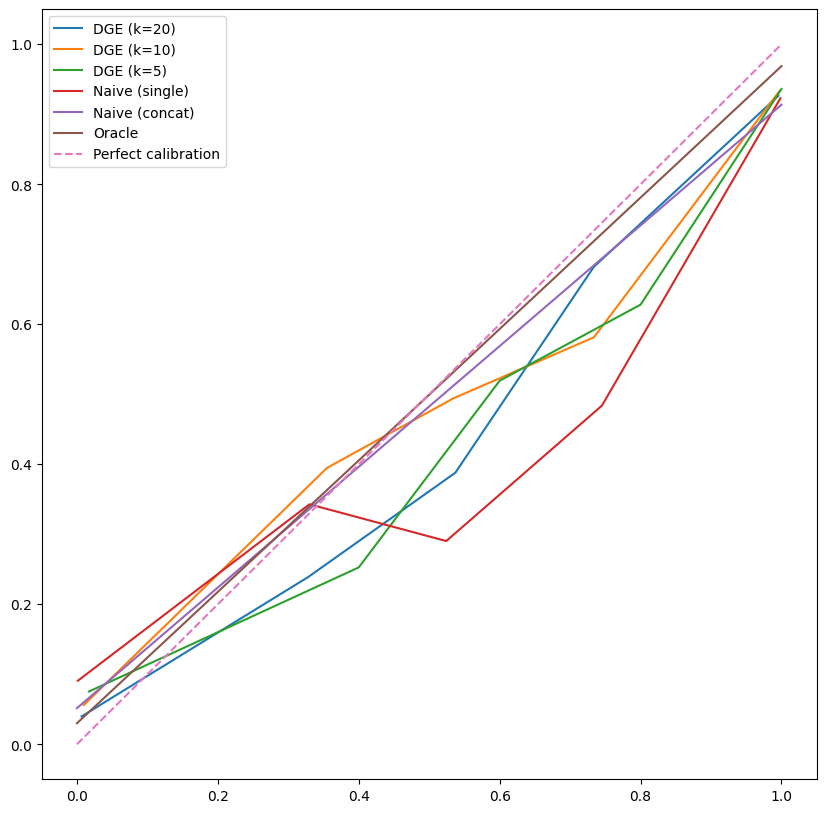

,roc_auc,accuracy,f1,precision,recall,nll,brier
DGE (k=20),0.954954,0.918250,0.920380,0.897010,0.94500,1.294111,0.068647
DGE (k=10),0.949194,0.915000,0.915000,0.915000,0.91500,1.496742,0.071884
DGE (k=5),0.943423,0.912875,0.912821,0.913392,0.91225,1.696757,0.074730
Naive (single),0.922943,0.912250,0.911654,0.917892,0.90550,2.611497,0.084886
Naive (concat),0.930375,0.930375,0.931749,0.913723,0.95050,2.404798,0.069625
Oracle,0.969375,0.969375,0.969394,0.968789,0.97000,1.057763,0.030625


In [ ]:
from DGE_experiments import predictive_experiment

y_preds, scores = predictive_experiment(X_gt,
                      X_syns,
                      workspace_folder=workspace_folder,
                      results_folder=results_folder,
                      save=save,
                      load=load)

scores


# Model Evaluation

We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow.
0. Train and generate synthetic datasets $S_i$.
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic dataset's test set $S_{i,test}$, giving $\hat{M}^S_i$ [Single performance]
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
5. Evaluate on the other synthetic datasets $\cup_{j\neq i} S_{j}$, giving $\hat{M}^G_i$ [Generative performance]
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 
7. Repeat 1-6 for different model classes $f$

N.B. the idea of the above, is that the trained model $f_i$ is the same for each evaluation type. In the model selection section, we will compare the performance of different model classes, where we will train a new model for each evaluation type (hence the aim is to evaluate which class is best, while the model itself may vary).

In [ ]:
from DGE_experiments import model_evaluation_experiment

if X_gt.targettype is not None:
    print('Aggregate approaches:')
    res = model_evaluation_experiment(X_gt, X_syns, workspace_folder=workspace_folder, model_type='mlp')[0]
    print(res)


Aggregate approaches:
             roc_auc      accuracy            f1     precision        recall  \
oracle  90.13 ± 1.95  90.13 ± 1.95  90.41 ± 1.83  88.18 ± 3.46  92.94 ± 3.29   
naive   90.33 ± 1.91  90.36 ± 1.86   90.5 ± 1.75  90.61 ± 2.45  90.42 ± 1.95   
dge     88.98 ± 0.79  88.98 ± 0.77  89.16 ± 0.83  89.29 ± 3.14  89.28 ± 3.85   

                   nll         brier  
oracle   340.9 ± 67.47   9.87 ± 1.95  
naive    332.87 ± 64.1   9.64 ± 1.86  
dge     380.58 ± 26.68  11.02 ± 0.77  


# Model Selection
Essentially repeat the above for different models

In [ ]:
from DGE_experiments import model_selection_experiment

if X_gt.targettype is not None:
    if X_gt.targettype == 'classification':
        metric = 'accuracy'
    elif X_gt.targettype == 'regression':
        metric = 'mse'
    
    results, means_sorted = model_selection_experiment(X_gt, X_syns, relative=False, metric=metric, workspace_folder=workspace_folder, load=load, save=save)


                  lr       xgboost           mlp            rf           knn  \
oracle  85.83 ± 0.77  89.96 ± 2.04  90.13 ± 1.95  90.27 ± 1.91  91.02 ± 1.81   
naive     2.9 ± 1.98   2.09 ± 1.69   2.04 ± 1.62   2.43 ± 1.49   2.39 ± 1.47   
dge      1.85 ± 0.48   2.79 ± 1.51   1.47 ± 1.03   2.52 ± 1.57     2.9 ± 1.5   

                 svm      deep_mlp  
oracle  91.62 ± 2.01  92.15 ± 1.91  
naive    2.54 ± 1.49   2.69 ± 1.56  
dge      2.54 ± 1.36   3.14 ± 1.61  
                lr  xgboost    mlp     rf    knn    svm  deep_mlp
oracle       85.83    89.96  90.13  90.27  91.02  91.62     92.15
naive         2.90     2.09   2.04   2.43   2.39   2.54      2.69
DGE           1.85     2.79   1.47   2.52   2.90   2.54      3.14
oracle rank   1.00     2.00   3.00   4.00   5.00   6.00      7.00
naive rank    7.00     2.00   1.00   4.00   3.00   5.00      6.00
DGE rank      2.00     5.00   1.00   3.00   6.00   4.00      7.00


## Influence of synthetic data size

Let's study the effect of synthetic data size.

In [ ]:
from DGE_experiments import predictive_varying_nsyn

predictive_varying_nsyn(X_gt, X_syns, dataset, model_name, n_models,
                        nsyn, results_folder, workspace_folder, load, save, verbose=True)


## Density estimation


In [ ]:
from DGE_experiments import density_experiment

if X_gt.targettype is None:
    density_experiment(X_gt, X_syns, load, save)


# Model parameter estimation
Using a linear model

# Cross validation

We compare the single baseline model vs the generative uncertainty model. Single workflow
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}$
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.

Versus our baseline
1. Take each synthetic dataset $S_i$ and split it up in train and test
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.


Cross-validation approach to test which type of model would perform best on real data. We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow Cross-validation.
0. Train and generate synthetic datasets $S_i$.
1. Use CV to train and evaluate models $f_i$ on each $S_i$. Repeat for all $S_i$. [Single performance]
2. Use CV \textit{over datasets $S_i$} (i.e. train on all but one $S_i$, evaluate on remaining and repeat) to train and evaluate models $f_i$.
3. For both cases, evaluate the model also on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
4. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 